In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import random
import heapq
from statistics import mode
from sklearn import metrics
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [120]:
def getDataPoints(filename):
    data = np.loadtxt(filename, delimiter=',', dtype=str)

    listofpoints = []

    for d in data:
        listofpoints.append(tuple(d))

    ans = []
    for tupl in listofpoints:
        temp = []
        for x in tupl:
            try:
                temp.append(float(x))
            except Exception:
                temp.append(x)
        ans.append(tuple(temp))

    return ans

def getDimensions(data):
    return len(data[0])

def getTrainingAndTestsPoints(data):

    seventyPercent = int((70/100)*len(data))
    random.shuffle(data)

    trainingPoints = data[:seventyPercent]
    testPoints = data[seventyPercent + 1:]

    return trainingPoints, testPoints

def getUniqueClasses(data):
    classes = []
    dimension = getDimensions(data)

    for p in data:
        if classes.count(p[dimension-1]) == 0:
            classes.append(p[dimension-1])

    return classes

In [121]:
class Node():
    def __init__(self, value, left, right):
        self.value = value
        self.left = left
        self.right = right

def printPreorder(node):

    if node:
        print(node.value)
        printPreorder(node.left)
        printPreorder(node.right)

def kdtree(point_list, depth=0):
    try:
        k = len(point_list[0]) - 1
    except IndexError as e:
        return None

    if len(point_list) == 1:
        return Node(value=point_list[0],left=None,right=None)

    axis = depth % k

    point_list.sort(key=lambda x: x[axis])
    
    l = len(point_list)
    if l%2 == 0:
        median = int((l/2)-1)
    else:
        median = l // 2

    return Node(
        value=point_list[median][axis],
        left=kdtree(point_list[:median+1], depth + 1),
        right=kdtree(point_list[median + 1:], depth + 1)
    )
class Kdtree():

    def buildKdtree(point_list):
        return kdtree(point_list)



In [122]:
def euclideanDistance(a, b):
    return np.linalg.norm(np.asarray(a)-np.asarray(b))

def k_nearestAux(dimensions, k, point, current_node, priority_queue=[], depth=0):

    axis = depth % (dimensions-1)
    depth += 1

    if current_node.left == None and current_node.right == None:
        distance = euclideanDistance(point[:dimensions-1], current_node.value[:dimensions-1])
        if len(priority_queue) < k:
            heapq.heappush(priority_queue, (-distance,current_node.value))
            priority_queue = sorted(priority_queue)

        elif -distance < -priority_queue[0][0]:
            heapq.heappushpop(priority_queue, (-distance, current_node.value))
            priority_queue = sorted(priority_queue)

        return priority_queue

    else:

        if point[axis] > current_node.value:
            nearBranch = current_node.right
            opositeBranch = current_node.left
        else:
            nearBranch = current_node.left
            opositeBranch = current_node.right

        priority_queue = k_nearestAux(dimensions, k, point, nearBranch, priority_queue, depth)

        if len(priority_queue) < k or priority_queue[0][1][axis] <= abs(point[axis] - current_node.value):

            priority_queue = k_nearestAux(dimensions, k, point, opositeBranch, priority_queue, depth)

        return priority_queue

class Xnn():

    def __init__(self, priority_queue):
        self.priority_queue = priority_queue
        self.kdtree = None

    def buildKdtree(self, point_list):
        self.kdtree = Kdtree.buildKdtree(point_list)

    def k_nearest(self, dimensions, k, point, current_node):
        self.priority_queue = k_nearestAux(dimensions, k, point, current_node, self.priority_queue, depth=0)

    def getClassificationFromPQ(self, dimensions):
        temp = []
        for p in self.priority_queue:
            temp.append(p[1][dimensions-1])

        return mode(temp)

    def getStatisticsFromTestPoints(self, k, test_point_list, classifications):
        
        tp = fp = tn = fn = 0
        dimensions = getDimensions(test_point_list)
        i = 0
        for point in test_point_list:
            self.k_nearest(dimensions, k, point, self.kdtree)
            classification = self.getClassificationFromPQ(dimensions)
            if point[dimensions-1] == classifications[0]:
                if classification == point[dimensions-1]:
                    tp += 1
                else:
                    fn += 1
            else:
                if classification == point[dimensions-1]:
                    tn += 1
                else:
                    fp += 1
        try:            
            precision = tp/(tp + fp) * 100
            revocation = tp/(tp+fn) * 100
            accuracy = (tp+tn)/(tp+tn+fp+fn) * 100
        except ZeroDivisionError:
            precision = revocation = 0
            accuracy = (tp+tn)/(tp+tn+fp+fn) * 100

        # print("Precisão: ", round(precision, 2), "%")
        # print("Revocação: ", round(revocation, 2), "%")
        # print("Acurácia: ", round(accuracy, 2), "%")

        return accuracy, revocation, precision

In [129]:
acc = []
recc = []
prec = []

naive_bayes_model = GaussianNB()
decision_tree_model = DecisionTreeClassifier(max_depth=7)
svm_model = svm.SVC(kernel='rbf')
knn_model = KNeighborsClassifier(n_neighbors=5)
random_forest_model = RandomForestClassifier(n_estimators=5)
gradient_tree_boosting = GradientBoostingClassifier(n_estimators=4)

models = [naive_bayes_model, decision_tree_model, svm_model, knn_model, random_forest_model, gradient_tree_boosting]
models_name = ['Naive Bayes', 'Decision Tree', 'SVM', 'KNN', 'Random Forest', 'Gradient Tree Boosting']

def getSklearnStatisticsFromTestPoints(X_train, X_test, y_train, y_test):

    for i in range(len(models)):
        model = models[i].fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("Modelo: ", models_name[i])
        acuraccy = metrics.accuracy_score(y_test, y_pred, normalize=True) * 100
        acc.append(acuraccy)
        recall = metrics.recall_score(y_test, y_pred, average='macro', zero_division=1) * 100
        recc.append(recall)
        precision = metrics.precision_score(y_test, y_pred, average='macro', zero_division=1) * 100
        prec.append(precision)

    return acc, recc, prec 

Quantidades de vizinhos próximos calculados:  5
Database: drug200
Modelo:  Naive Bayes
Modelo:  Decision Tree
Modelo:  SVM
Modelo:  KNN
Modelo:  Random Forest
Modelo:  Gradient Tree Boosting


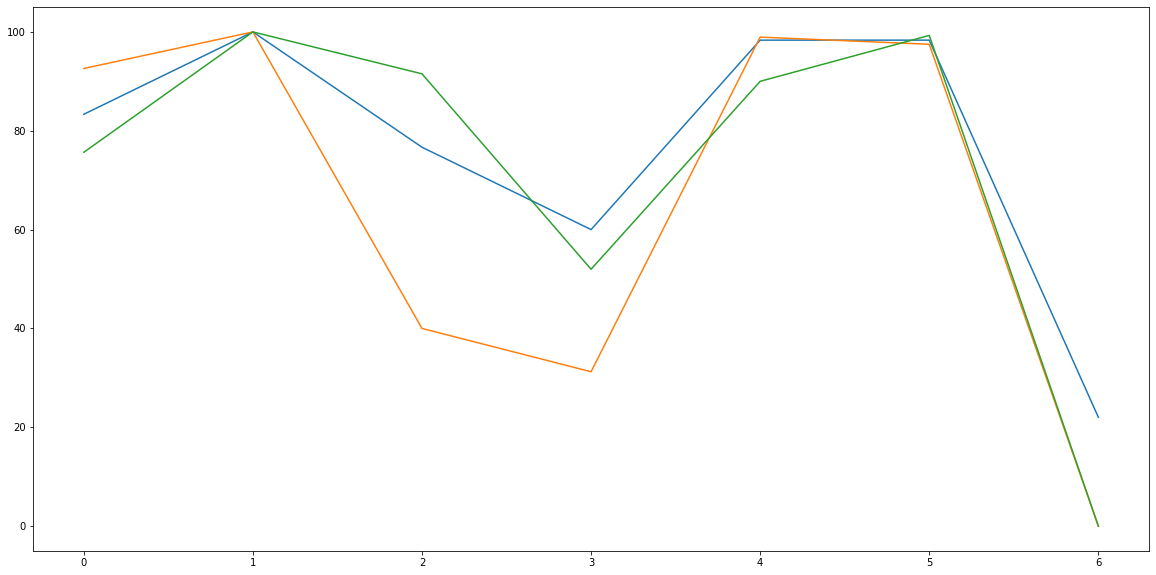

In [130]:
# databases = ['appendicitis', 'haberman', 'pima', 'led7digit', 'monk-2', 'heart', 'wdbc', 'phoneme', 'iris', 'ecoli', 'banana']
databases = ["drug200"]
models_name = ['Naive Bayes', 'Decision Tree', 'SVM', 'KNN', 'Random Forest', 'Gradient Tree Boosting', 'Xnn implementation']
plot_labels = ['', 'Revocation', 'Precision']

k = 5
print("Quantidades de vizinhos próximos calculados: ", k)

for database in databases:
    
    #run my implementation of Xnn
    print('Database: ' + database)
    point_list = getDataPoints('data/' + database + '.csv')
    trainingPoints, testPoints = getTrainingAndTestsPoints(point_list)

    xnn = Xnn(priority_queue=[])
    xnn.buildKdtree(trainingPoints)
    accuracy, revocation, precision = xnn.getStatisticsFromTestPoints(k, testPoints, getUniqueClasses(testPoints))

    #run sklearn models
    df = pd.read_csv('data/' + database + '.csv')
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    acc, recc, prec = getSklearnStatisticsFromTestPoints(X_train, X_test, y_train, y_test)

    acc.append(accuracy)
    recc.append(revocation)
    prec.append(precision)


    plt.figure(figsize=(20,10))
    plt.plot(acc, label = 'Accuracy')
    plt.plot(recc, label = 'Revocation')
    plt.plot(prec, label = 'Precision')

    plt.show()